In [314]:
import os
import pickle
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
import moviepy.editor as mpy
from tqdm import tqdm_notebook as tqdm

tflib.init_tf()

In [276]:
model = 'checkpoints/karras2019stylegan-bedrooms-256x256.pkl'
model = 'checkpoints/karras2019stylegan-cars-512x384.pkl'
model = 'checkpoints/karras2019stylegan-cats-256x256.pkl'
model = 'checkpoints/karras2019stylegan-celebahq-1024x1024.pkl'
model = 'checkpoints/karras2019stylegan-ffhq-1024x1024.pkl'

with open(model, 'rb') as f:
    _G, _D, Gs = pickle.load(f)

fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=8)


In [277]:
truncation = 0.5


def bookmark(latents, new_faves):
    for f in new_faves:
        faves.append(latents[f])

def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n-1, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)
        
def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

def get_latent_interpolation(endpoints, num_frames_per, mode, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    num_endpoints, dim = len(endpoints), len(endpoints[0])
    num_frames = num_frames_per * num_endpoints
    endpoints = np.array(endpoints)
    latents = np.zeros((num_frames, dim))
    for e in range(num_endpoints):
        e1, e2 = e, (e+1)%num_endpoints
        for t in range(num_frames_per):
            frame = e * num_frames_per + t
            r = 0.5 - 0.5 * np.cos(np.pi*t/(num_frames_per-1)) if mode == 'ease' else float(t) / num_frames_per
            latents[frame, :] = (1.0-r) * endpoints[e1,:] + r * endpoints[e2,:]
    return latents

def get_latent_interpolation_bspline(endpoints, nf, k, s, shuffle):
    if shuffle:
        random.shuffle(endpoints)
    x = np.array(endpoints)
    x = np.append(x, x[0,:].reshape(1, x.shape[1]), axis=0)
    nd = x.shape[1]
    latents = np.zeros((nd, nf))
    nss = list(range(1, 10)) + [10]*(nd-19) + list(range(10,0,-1))
    for i in tqdm(range(nd-9)):
        idx = list(range(i,i+10))
        tck, u = interpolate.splprep([x[:,j] for j in range(i,i+10)], k=k, s=s)
        out = interpolate.splev(np.linspace(0, 1, num=nf, endpoint=True), tck)
        latents[i:i+10,:] += np.array(out)
    latents = latents / np.array(nss).reshape((512,1))
    return latents.T


def generate_images(latents, labels):
    batch_size = 8
    num_frames = latents.shape[0]
    num_batches = int(np.ceil(num_frames/batch_size))
    images = []
    for b in tqdm(range(num_batches)):
        new_images = Gs.run(latents[b*batch_size:min((b+1)*batch_size, num_frames-1), :], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        for img in new_images:
            images.append(img)
    return images

def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        PIL.Image.fromarray(images[idx], 'RGB').save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)

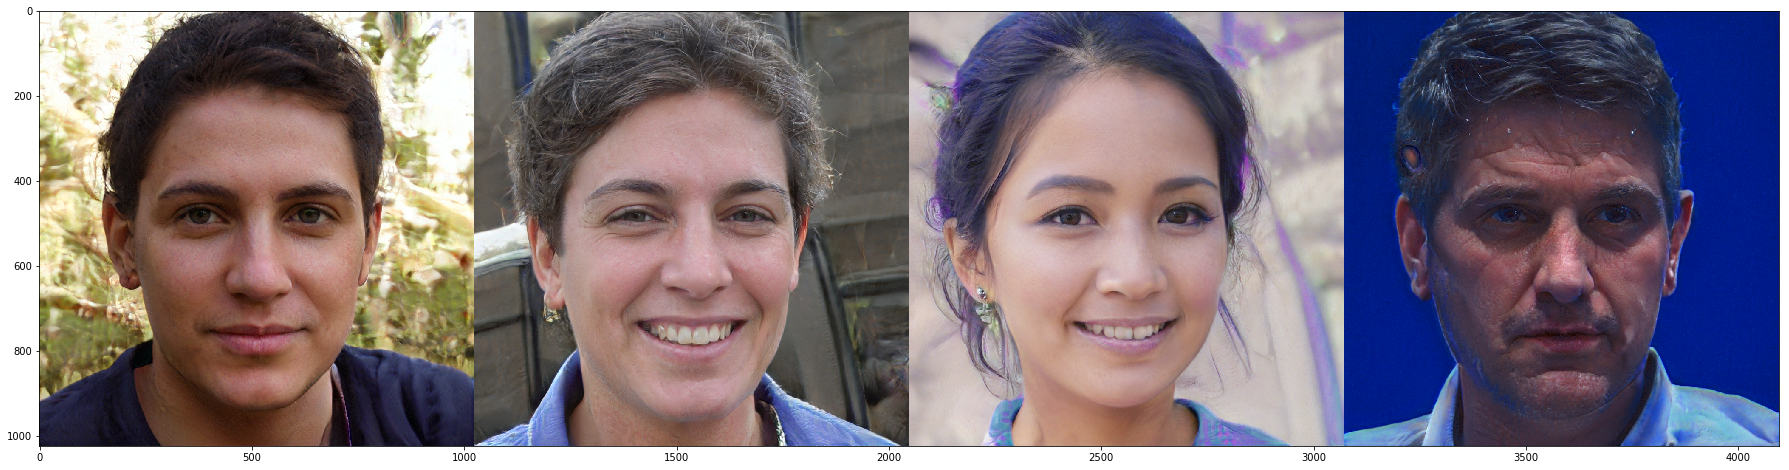

In [309]:

def random_sample(num_images, scale):
    latents = np.random.RandomState(int(1000*random.random())).randn(num_images, *Gs.input_shapes[0][1:])
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    images = Gs.run(latents, None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
    images_ct = np.concatenate([img for img in images], axis=1)
    plt.figure(figsize=(scale*num_images, scale))
    plt.imshow(images_ct)
    return images, latents

images, latents = random_sample(4, scale=8)

In [310]:
faves = []
bookmark(latents, [1])


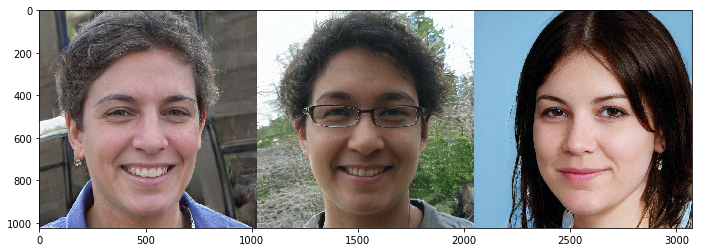

In [311]:
def show_faves(faves):
    latents = np.array(faves)
    labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])
    n = len(faves)
    nr, nc = math.ceil(n / 6), 6
    for r in range(nr):
        images = Gs.run(latents[6*r:min(n, 6*(r+1))], None, truncation_psi=truncation, randomize_noise=False, output_transform=fmt)
        img1 = np.concatenate([img for img in images], axis=1)
        plt.figure(figsize=(24,4))
        plt.imshow(img1)

show_faves(faves)


In [75]:
latents = get_latent_interpolation(faves, 25, 'linear', False)
labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

images = generate_images(latents, labels)    

make_movie(images, '.', 'faves2')

100%|██████████| 149/149 [00:03<00:00, 40.49it/s]


ffmpeg -i frames321134/frame%05d.png -c:v libx264 -pix_fmt yuv420p ./favecats.mp4


In [320]:
def make_movie(images, out_dir, out_name):
    temp_dir = 'frames%06d'%int(1000000*random.random())
    os.system('mkdir %s'%temp_dir)
    for idx in tqdm(range(len(images))):
        images[idx].save('%s/frame%05d.png' % (temp_dir, idx))
    cmd = 'ffmpeg -i %s/frame%%05d.png -c:v libx264 -pix_fmt yuv420p %s/%s.mp4' % (temp_dir, out_dir, out_name)
    print(cmd)
    os.system(cmd)
    os.system('rm -rf %s'%temp_dir)
    

src_latents = get_latent_interpolation(faves_src, 5, 'linear', False)
src_labels = np.zeros([latents.shape[0]] + Gs.input_shapes[1][1:])

src_images = generate_images(src_latents, src_labels)    


w = 1024
h = 1024
style_range=range(5,14)

n_src = len(faves_dst)
n_dst = 1

all_images = [] 
for s, src_latent in enumerate(src_latents):

    dst_z = src_latent.reshape((1,512))
    src_z = np.array(faves_dst).reshape((n_src,512))

    src_dlatents = Gs.components.mapping.run(src_z, None) # [seed, layer, component]
    dst_dlatents = Gs.components.mapping.run(dst_z, None) # [seed, layer, component]
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (n_src + 1), h * (n_dst + 1)), 'black')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))

    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * n_src)
        row_dlatents[:, style_range] = src_dlatents[:, style_range]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))

    all_images.append(canvas)

    
make_movie(all_images, '.', 'faves')

ffmpeg -i frames778902/frame%05d.png -c:v libx264 -pix_fmt yuv420p ./faves.mp4
